# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

Load data

In [2]:
df = pd.read_csv('consumption.csv')
weather_avg = pd.read_csv('weather-avg.csv')
weather_min = pd.read_csv('weather-min.csv')
weather_max = pd.read_csv('weather-max.csv')
info = pd.read_csv('addInfo.csv')

Functions

In [3]:
def get_mean_temp(row,month):
    if month==1:
        return row.loc[:,"2017-01-01 00:00:00":"2017-01-31 00:00:00"].mean(1)
    elif month==2:
        return row.loc[:,"2017-02-01 00:00:00":"2017-02-28 00:00:00"].mean(1)
    elif month==3:
        return row.loc[:,"2017-03-01 00:00:00":"2017-03-31 00:00:00"].mean(1)
    elif month==4:
        return row.loc[:,"2017-04-01 00:00:00":"2017-04-30 00:00:00"].mean(1)
    elif month==5:
        return row.loc[:,"2017-05-01 00:00:00":"2017-05-31 00:00:00"].mean(1)
    elif month==6:
        return row.loc[:,"2017-06-01 00:00:00":"2017-06-30 00:00:00"].mean(1)
    elif month==7:
        return row.loc[:,"2017-07-01 00:00:00":"2017-07-31 00:00:00"].mean(1)
    elif month==8:
        return row.loc[:,"2017-08-01 00:00:00":"2017-08-31 00:00:00"].mean(1)
    elif month==9:
        return row.loc[:,"2017-09-01 00:00:00":"2017-09-30 00:00:00"].mean(1)
    elif month==10:
        return row.loc[:,"2017-10-01 00:00:00":"2017-10-31 00:00:00"].mean(1)
    elif month==11:
        return row.loc[:,"2017-11-01 00:00:00":"2017-11-30 00:00:00"].mean(1)
    elif month==12:
        return row.loc[:,"2017-12-01 00:00:00":"2017-12-31 00:00:00"].mean(1)
    else:
        print("Error: this is not a valid input for month")

def get_monthi(n):
    begin=48*31*(n-1)+1
    end=48*31*n
    if n==1:
        begin=1
    if n>1:
        end-=3*48
    if n>2:
        begin-=3*48
    if n>3:
        end-=48
    if n>4:
        begin-=48
    if n>5:
        end-=48
    if n>6:
        begin-=48
    if n>8:
        end-=48
    if n>9:
        begin-=48
    if n>10:
        end-=48
    if n>11:
        begin-=48
    return begin,end

# Process data

In [4]:
brinfo=info.loc[:,["meter_id","num_bedrooms"]]
brinfomean=brinfo.mean()
brinfo=brinfo.fillna(value=brinfo.mean())
for i in range(0,df.shape[0]):
    meterid=df.loc[:,"meter_id"][i]
    row=brinfo.loc[brinfo['meter_id'] == meterid]
    if row.empty:
        #brinfo = pd.brinfo([meterid,brinfomean])
        #print(i)
        df2 = pd.DataFrame([[meterid, brinfomean]],columns=brinfo.columns)
        #df2 = pd.DataFrame([[meterid, brinfomean]],columns=brinfo.columns)
        brinfo=brinfo.append(df2)

In [5]:
temps=[]
temps_min=[]
temps_max=[]
En_con=[]
month_arr=[]
br_arr=[]

NaN_t=1200

#for i in range(0,df.shape[0]):

for i in range(0,df.shape[0]):
    #load rows
    meter=df.iloc[i]
    meterid=df.loc[:,"meter_id"][i]
    row_wa=weather_avg.loc[weather_avg['meter_id'] == meterid] #finds rown corresponding to the meter id 
    row_wm=weather_min.loc[weather_min['meter_id'] == meterid]
    row_wM=weather_max.loc[weather_max['meter_id'] == meterid]
    row_br=brinfo.loc[brinfo['meter_id'] == meterid]
    
    # loop over all months
    for m in range (1,13):
        ind_b,ind_e=get_monthi(m)               #get index of beginning and end of month
        month=meter[ind_b:ind_e]

        # Check if months has numeric values        
        n_NaN=month.isnull().sum() #Number of NaN's
        if n_NaN<NaN_t:
            temps.append(get_mean_temp(row_wa,m))
            temps_min.append(get_mean_temp(row_wm,m))
            temps_max.append(get_mean_temp(row_wM,m))
            En_con.append(month.mean())
            month_arr.append(m)
            br_arr.append(row.loc[:,"num_bedrooms"])

In [6]:
nptemps=np.array(temps)
nptemps_min=np.array(temps_min)
nptemps_max=np.array(temps_max)
npEn_con=np.array(En_con)
npmonth_arr=np.array(month_arr)
npbr_arr=np.array(br_arr)

In [7]:
combinefeatures=[]
for i in range(len(temps)):
    temp=[]
    temp.append(temps[i])
    temp.append(temps_min[i])
    temp.append(temps_max[i])
    temp.append(month_arr[i])
    temp.append(br_arr[i])
    combinefeatures.append(temp)
    
npcombinefeatures=np.array(combinefeatures)
npcombinefeatures=npcombinefeatures.reshape(-1,5)

d:\programmas\anaconda\envs\forcastenv\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


# Models

Neural network

In [8]:
x_train=npcombinefeatures[:-2000]
x_test=npcombinefeatures[-2000:]

y_train=npEn_con[:-2000]
y_test= npEn_con[-2000:]
# normalise the samples
mu, sigma = np.mean(x_train, axis=0), np.std(x_train, axis=0)
x_train -= mu
x_train /= sigma

x_test -= mu
x_test /= sigma

# construct the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, input_dim=13, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])
print(model.summary())

TypeError: loop of ufunc does not support argument 0 of type Series which has no callable conjugate method

In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
print("Start training")
# train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

# evaluate the model
mse = model.evaluate(x_test, y_test)[1]
print(f'MSE: {mse}')

ARIMA <br>
stolen from :https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [9]:
from pandas.plotting import autocorrelation_plot

In [10]:
df.mean()

2017-01-01 00:00:00    0.166211
2017-01-01 00:30:00    0.305056
2017-01-01 01:00:00    0.238358
2017-01-01 01:30:00    0.226979
2017-01-01 02:00:00    0.223267
                         ...   
2017-12-31 21:30:00    0.238220
2017-12-31 22:00:00    0.228226
2017-12-31 22:30:00    0.210127
2017-12-31 23:00:00    0.197075
2017-12-31 23:30:00    0.184235
Length: 17520, dtype: float64

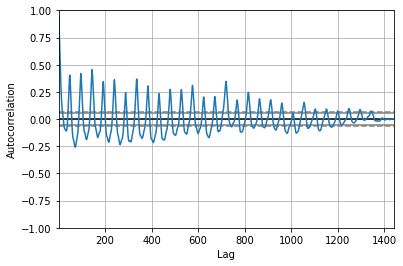

In [12]:
autocorrelation_plot(df.loc[:,"2017-12-01 00:00:00":"2017-12-31 00:00:00"].mean())
plt.show()

In [21]:
from statsmodels.tsa.arima_model import ARIMA

In [46]:
dfmean=df.mean()
wm=[] #df weekly mean
#each week is 48*7 indicises
for i in range(1,52):
    b=(i-1)*7*48
    e=i*7*48
    wm.append(dfmean.iloc[b:e].mean())

dfwm=  pd.DataFrame({'Consumption': wm})

In [47]:
dfwm

,Consumption
0,0.263079
1,0.272997
2,0.259532
3,0.265238
4,0.246860
5,0.261092
6,0.250746
7,0.228306
8,0.235418
9,0.220530


In [34]:
#dfmean.iloc[1:7*48].mean()
i=2
b=(i-1)*7*48
e=i*7*48
dfmean.iloc[b:e]

2017-01-08 00:00:00    0.149056
2017-01-08 00:30:00    0.250043
2017-01-08 01:00:00    0.207189
2017-01-08 01:30:00    0.184009
2017-01-08 02:00:00    0.184738
                         ...   
2017-01-14 21:30:00    0.268022
2017-01-14 22:00:00    0.267870
2017-01-14 22:30:00    0.228346
2017-01-14 23:00:00    0.191563
2017-01-14 23:30:00    0.166829
Length: 336, dtype: float64

d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.Consumption   No. Observations:                   50
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 143.588
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 05 Nov 2020   AIC                           -273.177
Time:                        20:17:10   BIC                           -259.793
Sample:                             1   HQIC                          -268.080
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.646e-05      0.003     -0.018      0.985      -0.005       0.005
ar.L1.D.Consumption    -0.4206      0.163     -2.575      0.010      -0.741      -0.100
ar.L2.D.Consumpt

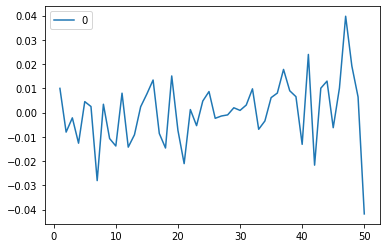

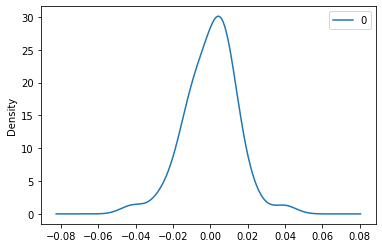

               0
count  50.000000
mean    0.000265
std     0.013752
min    -0.041781
25%    -0.007876
50%     0.002184
75%     0.008499
max     0.039697


In [48]:
# fit model
model = ARIMA(dfwm, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or

predicted=0.152107, expected=0.153319


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWar

predicted=0.149783, expected=0.155295


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.150556, expected=0.161345


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWar

predicted=0.152935, expected=0.168485


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.163456, expected=0.181573


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.178494, expected=0.187818


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.189877, expected=0.197312


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.202709, expected=0.185972


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.194267, expected=0.221959


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecat

predicted=0.215863, expected=0.186950


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.208510, expected=0.219625


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.210141, expected=0.214680


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.215783, expected=0.222733


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.227193, expected=0.222460


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.227909, expected=0.273493


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.249274, expected=0.271238


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=0.285499, expected=0.290372


d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\programmas\anaconda\envs\forcastenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecat

predicted=0.301738, expected=0.248477
Test MSE: 0.00046551


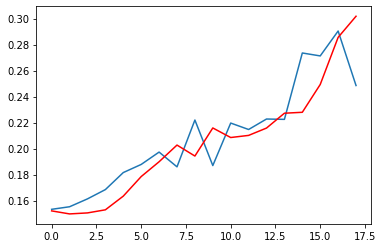

In [104]:
X=dfwm.values
#lot's of bs to get a better test set
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]


history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.8f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [80]:
np.reshape(test,[16])


array([0.26307867, 0.27299727, 0.25953162, 0.26523849, 0.24685975,
       0.26109156, 0.25074595, 0.22830561, 0.21962466, 0.21468019,
       0.22273293, 0.22246002, 0.27349271, 0.27123835, 0.29037243,
       0.24847714])

MSE ARIMA:<br>
Autoregression:<br>
(0,0,0)  0.00178953 -> White noise <br>
(1,0,0)  0.00048808<br>
(4,0,0)  0.00045111<br>
(5,0,0)  0.00044017 -> Best Autoregression<br>
(6,0,0)  0.00048930<br>
Moving Average:<br>
(0,0,1)  0.00140471<br>
(0,0,3)  0.00064410 -> lot's of warnings<br>
Mix:<br>
(5,0,1)  0.00045250 -> lot's of warnings<br>
(5,1,0)  0.00051118<br>
(3,1,1)  0.00046551<br>
(3,2,1)  0.00046502<br>